# DreamBooth Hackathon 🏆

Welcome to the DreamBooth Hackathon! 在这个笔记本中，我们会尝试 **用小部分图片训练个性化的Stable Diffusion model**。 为了做到这个，我们需要运用 [_DreamBooth_](https://arxiv.org/abs/2208.12242), 它允许我们把一个原模型没见过的类别(比如：你最喜欢的一道菜或者你的小宠物) 嵌入output中，并在prompt中用一个`unique identifier` 去调用它。

from [this notebook](https://colab.research.google.com/github/huggingface/diffusion-models-class/blob/main/hackathon/dreambooth.ipynb)

Link start!

## 准备

最好先读读。。。
* [Unit 3 README](https://github.com/huggingface/diffusion-models-class/blob/main/unit3/README.md) that contains a deep dive into Stable Diffusion
* DreamBooth [blog post](https://dreambooth.github.io/) to get a sense of what's possible with this technique
* Hugging Face [blog post](https://huggingface.co/blog/dreambooth) on best practices for fine-tuning Stable Diffusion with DreamBooth

🚨 **Note:** 想运行这个notebook **需要至少14GB显存** ！而且，这是一个简化版本，完整版在[这里](https://github.com/huggingface/diffusers/tree/main/examples/dreambooth). 如果你有24GB显存，那么推荐你再看看完整版的代码，并调整一些高级的feature（e.g. class preservation loss & fine-tuning the text encoder ） 。 参见 🤗 Diffusers [文档](https://huggingface.co/docs/diffusers/training/dreambooth) for more details.

## 什么是DreamBooth？

DreamBooth是一种fine-tune方法，它可以教会Stable Diffusion新的概念。
DreamBooth is a technique to teach new concepts to Stable Diffusion using a specialized form of fine-tuning.

DreamBooth的工作方式如下:

* 收集大约10-20张主体（如你的狗）的输入图像，并定义一个独特的标识符[V]，以指代主体。这个标识符通常是一些编造出来的词，如flffydog，在推理时被植入不同的文本提示中，以将主体置于不同的语境中。
* 通过提供图像和文本提示，如 "一只[V]狗的照片"，其中包含唯一的标识符和类名（即本例中的 "狗"），来微调扩散模型。
* (Optionally) 应用一个特殊的 _类别先验保持 loss_, 它利用了模型对类的语义先验，并鼓励它通过在文本提示中注入类的名称来产生属于主体类的不同实例。在实践中，这一步只对人脸有真正的需要，对于我们将在这次黑客马拉松中探索的主题可以跳过。

DreamBooth技术的概述如下图所示：


![](https://dreambooth.github.io/DreamBooth_files/high_level.png)

## What can DreamBooth do?

用文本prompt实现同一个物体的多视角模拟 （i.e. _**text-guided view synthesis**_ ）例如：

![](https://dreambooth.github.io/DreamBooth_files/novel_views.png)

改变物体的某种属性，例如

![](https://dreambooth.github.io/DreamBooth_files/property_modification.png)

现在，让我们开始训练自己的模型吧

## Step 1: SetUp

首先参照[this notebook](https://colab.research.google.com/github/huggingface/diffusion-models-class/blob/main/hackathon/dreambooth.ipynb)安装好环境，这里已经配置完毕，便跳过

## Step 2: 创建自己的数据集（包括上传到HF的方法）

Once you've picked a theme, the next step is to **create a dataset of images for that theme** and upload it to the Hugging Face Hub:

* You'll need around **10-20 images of the subject** that you wish to implant in the model. These can be photos you've taken or downloaded from platforms like [Unsplash](https://unsplash.com/). Alternatively, you can take a look at any of the [image datasets](https://huggingface.co/datasets?task_categories=task_categories:image-classification&sort=downloads) on the Hugging Face Hub for inspiration.
* For best results, we recommend using images of your subject from **different angles and perspectives** 

图形化创建并上传数据
* See [this guide](https://huggingface.co/docs/datasets/upload_dataset#upload-with-the-hub-ui)
* See [this video](https://www.youtube.com/watch?v=HaN6qCr_Afc&ab_channel=HuggingFace)

在本地创建数据集（并push到hub上）

In [ ]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="your_folder_of_images")
# Remove the dummy label column
dataset = dataset.remove_columns("label")
# Push to Hub
dataset.push_to_hub("dreambooth-hackathon-images")

*Once* you've created your dataset, you can download it by using the `load_dataset()` function as follows:

In [1]:
from datasets import load_dataset
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from transformers import CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel
from transformers import CLIPFeatureExtractor, CLIPTextModel
import torch
from argparse import Namespace


dataset_id = "lewtun/corgi"  # CHANGE THIS TO YOUR {hub_username}/{dataset_id}
dataset = load_dataset(dataset_id, split="train")
print(dataset) # 只有5张图片的柯基数据集

Found cached dataset parquet (/root/.cache/huggingface/datasets/lewtun___parquet/lewtun--corgi-387a0d84d49c152d/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Dataset({
    features: ['image'],
    num_rows: 5
})


数据可视化：

In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


num_samples = 4
image_grid(dataset["image"][:num_samples], rows=1, cols=num_samples)

If this looks good, you can move onto the next step - creating a PyTorch dataset for training with DreamBooth.

## Step 3: 创建训练集

Dreambooth训练数据包含以下几个部分：

* 一个用来激励模型训练的特殊prompt _instance prompt_ 。大多数情况下可以使用如下描述：
  *  "a photo of [identifier] [class noun]"
  *  例如上面的的柯基："a photo of **ccorgi** dog"
    * **Note:** 推荐使用特殊词语，或者现实中不存在的词（避免出现在预训练模型的训练集中，否则新的训练会覆盖原始模型中对该词语的理解，从而和目标混淆），就像上面使用的 ‘ccorgi’。
* _tokenizer_ to convert the instance prompt into input IDs that can be fed to the text encoder of Stable Diffusion
* A set of _image transforms_, notably resizing the images to a common shape and normalizing the pixel values to a common mean and standard distribution.

With this in mind, let's start by defining the instance prompt:


In [3]:
name_of_your_concept = "ccorgi"  # CHANGE THIS ACCORDING TO YOUR SUBJECT
type_of_thing = "dog"  # CHANGE THIS ACCORDING TO YOUR SUBJECT
instance_prompt = f"a photo of {name_of_your_concept} {type_of_thing}"
print(f"Instance prompt: {instance_prompt}")

Instance prompt: a photo of ccorgi dog


创建一个DB专用的dataset，重写`__len__` and `__getitem__` 以兼容训练
Next, we need to create a PyTorch `Dataset` object that implements the `__len__` and `__getitem__` dunder methods:

In [5]:
class DreamBoothDataset(Dataset):
    def __init__(self, dataset, instance_prompt, tokenizer, size=512):
        self.dataset = dataset
        self.instance_prompt = instance_prompt
        self.tokenizer = tokenizer
        self.size = size
        self.transforms = transforms.Compose(
            [
                transforms.Resize(size),
                transforms.CenterCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        example = {}
        image = self.dataset[index]["image"]
        example["instance_images"] = self.transforms(image) # 做变换后的图像
        example["instance_prompt_ids"] = self.tokenizer(
            self.instance_prompt,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids # tokenizer 处理后的prompt
        return example

Great, let's now check this works by loading the CLIP tokenizer 
associated with the text encoder of the original Stable Diffusion model, and then creating the training dataset:
接下来，用clip tokenizer将我们的prompt转化为vector。。。

**思考：** 非常反直觉的一点是，由于CLIP tokenizer可以将没见过的描述也拆成独一无二的表述，所以CLIP的参数反而不用特别训练。。。

**问题：** 在什么情况下需要对CLIP的参数进行训练？如何微调CLIP参数？

In [6]:

# The Stable Diffusion checkpoint we'll fine-tune
model_id = "/workspace/data2/huggingface-models/stable-diffusion-v1-4/"
tokenizer = CLIPTokenizer.from_pretrained(
    model_id,
    subfolder="tokenizer",
)

train_dataset = DreamBoothDataset(dataset, instance_prompt, tokenizer)
train_dataset[0]

{'instance_images': tensor([[[ 0.7804,  0.7882,  0.8039,  ...,  0.7569,  0.7569,  0.7412],
          [ 0.7882,  0.7961,  0.8196,  ...,  0.7412,  0.7333,  0.7333],
          [ 0.7804,  0.7804,  0.7804,  ...,  0.7490,  0.7412,  0.7569],
          ...,
          [ 0.7255,  0.7255,  0.7255,  ...,  0.7412,  0.7412,  0.7333],
          [ 0.7098,  0.7255,  0.7333,  ...,  0.7333,  0.7255,  0.7333],
          [ 0.7098,  0.7098,  0.7176,  ...,  0.7333,  0.7255,  0.7255]],
 
         [[-0.0039, -0.0039,  0.0039,  ..., -0.2706, -0.2706, -0.2784],
          [-0.0039, -0.0039,  0.0196,  ..., -0.2863, -0.2863, -0.2863],
          [-0.0353, -0.0353, -0.0196,  ..., -0.2784, -0.2863, -0.2784],
          ...,
          [-0.3333, -0.3333, -0.3333,  ..., -0.2000, -0.2078, -0.2157],
          [-0.3490, -0.3333, -0.3255,  ..., -0.2314, -0.2314, -0.2235],
          [-0.3490, -0.3490, -0.3412,  ..., -0.2471, -0.2471, -0.2471]],
 
         [[-0.6000, -0.6000, -0.5843,  ..., -0.6549, -0.6627, -0.6706],
         

## Step 4: Define a data collator

现在我们有了一个训练数据集，接下来我们需要的是定义一个data collator。data collator是一个函数，它收集一批数据中的元素，并应用一些逻辑来形成一个我们可以提供给模型的单一张量

其实就是把原始数据转换为一个标准的batch的过程，dataloader做的事情其实就包括了 data collator

check this [video](https://youtu.be/-RPeakdlHYo)


In [7]:


def collate_fn(examples):
    input_ids = [example["instance_prompt_ids"] for example in examples]
    pixel_values = [example["instance_images"] for example in examples]
    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    input_ids = tokenizer.pad(
        {"input_ids": input_ids}, padding=True, return_tensors="pt"
    ).input_ids

    batch = {
        "input_ids": input_ids,
        "pixel_values": pixel_values,
    }
    return batch

## Step 5: 载入SD管道的所有部件

我们几乎已经为训练准备好了所有的部件! 正如 Unit 3 notebook on Stable Diffusion 所说, 管道是由几个模型组成的：

* 一个文本编码器，将提示信息转换为文本嵌入。在这里，我们使用CLIP，因为它是用于训练 Stable Diffusion v1-4
* A VAE or variational autoencoder 将图像转换为 compressed representations (i.e. latents) 并在推理时将其解压
* A UNet 对VAE的latent进行去噪操作。

We can load all these components using the 🤗 Diffusers and 🤗 Transformers libraries as follows:

In [8]:
model_id = "/workspace/data2/huggingface-models/stable-diffusion-v1-4/"
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
feature_extractor = CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.8/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


## Step 6: Fine-tune the model

训练自己的 DreamBooth! 在 [HF的推文](https://huggingface.co/blog/dreambooth)里了解到, 最重要的 hyperparameters 是 learning rate 和 number of training steps.

总而言之，小学习率多训练步数（小步快跑）能取得一个较好的结果。下面的值是一个很好的起点，但你可能需要根据你的数据集来调整它们: 

In [41]:
learning_rate = 2e-06
max_train_steps = 400

args = Namespace(
    pretrained_model_name_or_path=model_id,
    resolution=512, # Reduce this if you want to save some memory
    train_dataset=train_dataset,
    instance_prompt=instance_prompt,
    learning_rate=learning_rate,
    max_train_steps=max_train_steps,
    train_batch_size=1,
    gradient_accumulation_steps=1, # Increase this if you want to lower memory usage
    max_grad_norm=1.0,
    gradient_checkpointing=True,  # set this to True to lower the memory usage.
    use_8bit_adam=True,  # use 8bit optimizer from bitsandbytes
    seed=3434554,
    sample_batch_size=2,
    output_dir="my-dreambooth",  # where to save the pipeline
    # device = 'cuda:1'
)

写训练loop，应用Accelerate

[视频指南](https://www.youtube.com/watch?v=s7dy8QRgjJ0&ab_channel=HuggingFace)

In [55]:
import math

import torch.nn.functional as F
from accelerate import Accelerator
from accelerate.utils import set_seed
from diffusers import DDPMScheduler, PNDMScheduler, StableDiffusionPipeline
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from torch.utils.data import DataLoader
from tqdm.auto import tqdm


def training_function(text_encoder, vae, unet):

    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
    )

    set_seed(args.seed)

    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()

    # Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
    if args.use_8bit_adam:
        import bitsandbytes as bnb
        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW

    optimizer = optimizer_class(
        unet.parameters(),  # only optimize unet
        lr=args.learning_rate,
    )

    noise_scheduler = DDPMScheduler(
        beta_start=0.00085,
        beta_end=0.012,
        beta_schedule="scaled_linear",
        num_train_timesteps=1000,
    )

    train_dataloader = DataLoader(
        args.train_dataset,
        batch_size=args.train_batch_size,
        shuffle=True,
        collate_fn=collate_fn,
    )

    unet, optimizer, train_dataloader = accelerator.prepare(
        unet, optimizer, train_dataloader
    )

    # Move text_encode and vae to gpu
    text_encoder.to(accelerator.device)
    vae.to(accelerator.device)

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(
        len(train_dataloader) / args.gradient_accumulation_steps
    )
    num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = (
        args.train_batch_size
        * accelerator.num_processes
        * args.gradient_accumulation_steps
    )
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(
        range(args.max_train_steps), disable=not accelerator.is_local_main_process
    )
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        unet.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Convert images to latent space
                with torch.no_grad():
                    latents = vae.encode(batch["pixel_values"]).latent_dist.sample()
                    latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn(latents.shape).to(latents.device)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(
                    0,
                    noise_scheduler.config.num_train_timesteps,
                    (bsz,),
                    device=latents.device,
                ).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                with torch.no_grad():
                    encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(
                    noisy_latents, timesteps, encoder_hidden_states
                ).sample
                loss = (
                    F.mse_loss(noise_pred, noise, reduction="none")
                    .mean([1, 2, 3])
                    .mean()
                )

                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(unet.parameters(), args.max_grad_norm)
                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= args.max_train_steps:
                break

        accelerator.wait_for_everyone()

    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        print(f"Loading pipeline and saving to {args.output_dir}...")
        scheduler = PNDMScheduler(
            beta_start=0.00085,
            beta_end=0.012,
            beta_schedule="scaled_linear",
            skip_prk_steps=True,
            steps_offset=1,
        )
        pipeline = StableDiffusionPipeline(
            text_encoder=text_encoder,
            vae=vae,
            unet=accelerator.unwrap_model(unet),
            tokenizer=tokenizer,
            scheduler=scheduler,
            safety_checker=StableDiffusionSafetyChecker.from_pretrained(
                "CompVis/stable-diffusion-safety-checker"
            ),
            feature_extractor=feature_extractor,
        )
        pipeline.save_pretrained(args.output_dir)


In [ ]:
from accelerate import notebook_launcher

num_of_gpus = 1  # CHANGE THIS TO MATCH THE NUMBER OF GPUS YOU HAVE
notebook_launcher(
    training_function, args=(text_encoder, vae, unet), num_processes=num_of_gpus
)

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

在这里有一个大坑，pytorch2.0似乎不兼容Accelerate包，或者是别的包对2.0适配不好，无法计算反向传播的gradient导致CUDA error

回滚到 torch1.13 解决

ps2： 用 torch2也可以，但是一定要设置成default `accelerate config default`

这里也没有用以上代码训练，用的代码在[这里](https://github.com/huggingface/diffusers/tree/main/examples/dreambooth)

很惊讶的是，torch1.13 4090都无法跑起来512*512的混合精度训练。。。需要使用8精度才可以。。。

torch2 只需要21G就可以了！


## Step 7: 用微调好的生成图形

Now that we've trained the model, let's generate some images with it to see how it fares! First we'll load the pipeline from the output directory we save the model to:


In [13]:
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained(
    './saved_DreamB_ori',
    torch_dtype=torch.float16,
).to("cuda:1")

Next, let's generate a few images. The `prompt` variable will later be used to set the default on the Hugging Face Hub widget, so experiment a bit to find a good one. You might also want to try creating elaborate prompts with [CLIP Interrogator](https://huggingface.co/spaces/pharma/CLIP-Interrogator):

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

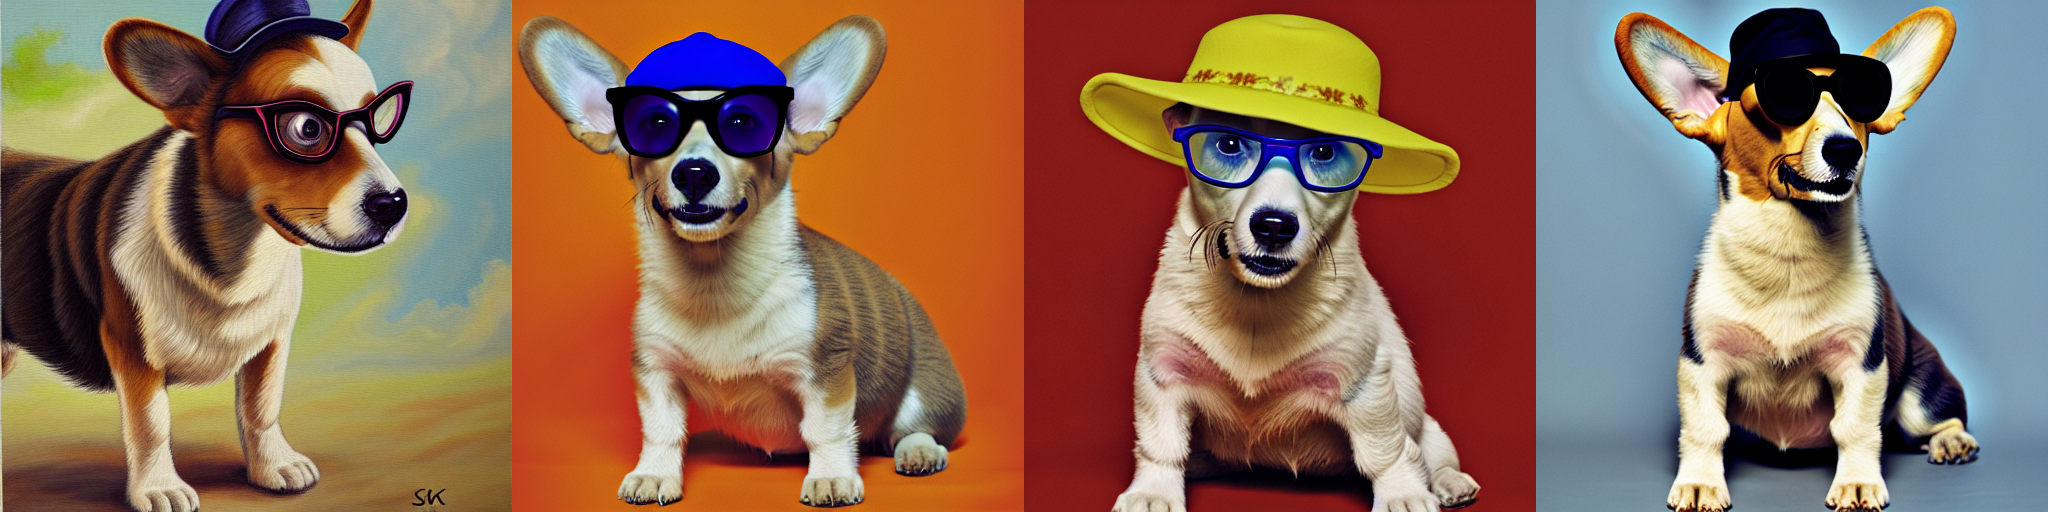

In [16]:
name_of_your_concept = 'sks' 
type_of_thing = 'dog'

# Pick a funny prompt here and it will be used as the widget's default 
# when we push to the Hub in the next section
prompt = f"a painting of {name_of_your_concept} {type_of_thing} with hat and glasses"

# Tune the guidance to control how closely the generations follow the prompt.
# Values between 7-11 usually work best
guidance_scale = 9

num_cols = 4
all_images = []
for _ in range(num_cols):
    images = pipe(prompt, guidance_scale=guidance_scale).images
    all_images.extend(images)

image_grid(all_images, 1, num_cols)

实验表明：DreamBooth可以画出来很像原图的作品，但是问题在于：他画的太像训练数据了，也就是说overfitting很重。